In [50]:
import numpy as np
import gc
import pandas as pd
import matplotlib.pyplot as plt
csfont = {'fontname':'Times New Roman'}
import hdbscan
import seaborn as sns
from pathlib import Path
from scipy.spatial import distance_matrix

In [51]:
def read_bl2(path):
    return np.core.records.fromfile(str(path),formats='i8,(2048)i2',names='index,wave')

In [52]:
def read_truth(path):
    return np.core.records.fromfile(str(path),formats='i8,i2,i2,(6)i2,i2,i2',names='index,label,numPro,naught,T0,max')

In [53]:
basepath = Path("/Users/elicarter/Local/FominResearch/RealData/Runs/pseudoData/sim100k_wfs.dat")
saturatedData = read_bl2(basepath)["wave"]
#CUT OFF AT 10K EVENTS
cutOff = 10000
saturatedData = saturatedData[:cutOff] 

In [54]:
truthTable = read_truth(Path("/Users/elicarter/Local/FominResearch/RealData/Runs/pseudoData/sim100k_proEventList.dat"))["label"]
truthTable = truthTable[:cutOff]

In [55]:
bad_locations = np.where(saturatedData > 30000)
bad_ys = np.unique(bad_locations[0])
data = np.delete(saturatedData, bad_ys, axis=0)
truthTable = np.delete(truthTable, bad_ys, axis=0)

In [56]:
#np.random.shuffle(data)
print(np.shape(saturatedData))
print(np.shape(data))
del saturatedData
gc.collect()

(10000, 2048)
(9961, 2048)


31469

In [57]:
colors = {}
colors[-1] = 'black'
colors[0] = 'r'
colors[1] = 'g'
colors[2] = 'b'
colors[3] = 'c'
colors[4] = 'm'
colors[5] = 'y'
colors[6] = 'pink'
colors[7] = 'purple'
colors[8] = 'silver'
colors[9] = 'brown'
colors[10] = 'olive'
colors[11] = 'aquamarine'
colors[12] = 'cornflowerblue'
colors[13] = 'teal'
colors[14] = 'salmon'
colors[15] = 'lime'
colors[16] = 'gold'

# Dimensionality Reduction using principal component analysis

In [58]:
u, s, vh = np.linalg.svd(data, full_matrices=False)

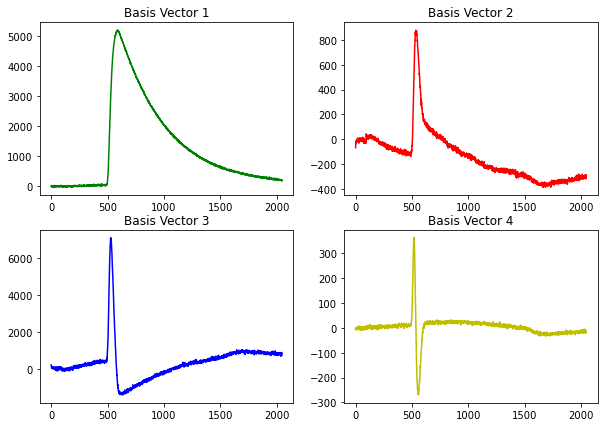

In [59]:
fig, ax = plt.subplots(2,2, figsize = (10,7))
ax[0,0].plot(u[0,0]*s[0]*vh[0], color = 'g')
ax[0,0].title.set_text("Basis Vector 1")
ax[0,1].plot(u[1,1]*s[1]*vh[1], color = 'r')
ax[0,1].title.set_text("Basis Vector 2")
ax[1,0].plot(u[2,2]*s[2]*vh[2], color = 'b')
ax[1,0].title.set_text("Basis Vector 3")
ax[1,1].plot(u[3,3]*s[3]*vh[3], color = 'y')
ax[1,1].title.set_text("Basis Vector 4")

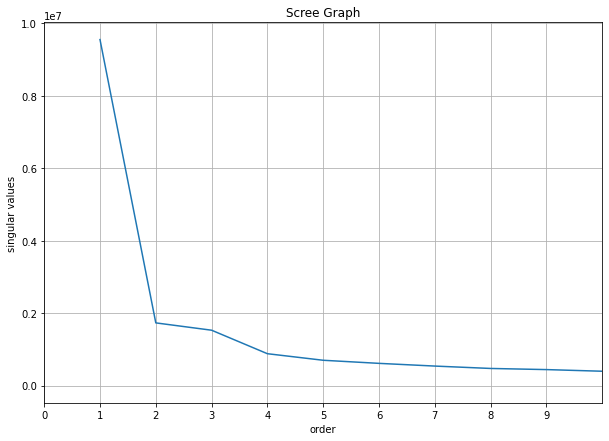

In [60]:
scree_order = np.arange(1,len(s)+1)
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, s)
ax.title.set_text("Scree Graph")
ax.set_ylabel("singular values")
ax.set_xlabel("order")
ax.set_xlim([0,10])
ax.set_xticks(np.arange(0,10))
plt.grid()
plt.show()

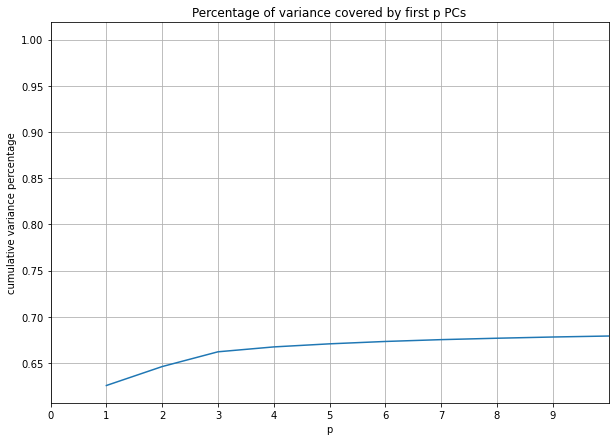

In [61]:
variance = np.zeros_like(s)
for i in range(len(s)):
    variance[i] = s[i]**2
total_variance = 0
for i in range(len(variance)):
    total_variance += variance[i]
    
pvc = np.zeros_like(variance)
for i in range(len(pvc)):
    pvc[i] = variance[i] + pvc[i-1]
for i in range(len(pvc)):
    pvc[i] = pvc[i] / total_variance
    
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, pvc)
ax.title.set_text('Percentage of variance covered by first p PCs')
ax.set_xlabel('p')
ax.set_ylabel('cumulative variance percentage')
ax.set_xlim(0,10)
ax.set_xticks(np.arange(0,10))
plt.grid()
plt.show()

In [62]:
v = np.transpose(vh)
vD = v[:,:2]
rDataD = data@vD

(-335907.0705117894, 573821.152340372, -235216.38125305396, 574318.5623494746)

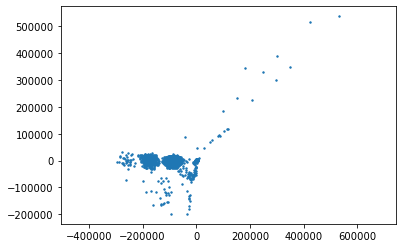

In [63]:
plt.scatter(-1*rDataD[:,0], rDataD[:,1], s=2)
plt.axis("equal")

In [64]:
del u, s, vh, vD
gc.collect()

15416

# Start HDBSCAN

In [65]:
doubleDistances = distance_matrix(rDataD, rDataD)
#double counts distances. Get upper triangle matrix then manipulate it 
temp = np.triu(doubleDistances)
distances = np.asarray(temp).reshape(-1)
distances = np.sort(distances)
distances = np.flip(distances)
#remove 0s where repeats used to be
nonzeros = int((len(doubleDistances)*len(doubleDistances) - 1)/2)
distances = distances[0:nonzeros]
order = np.arange

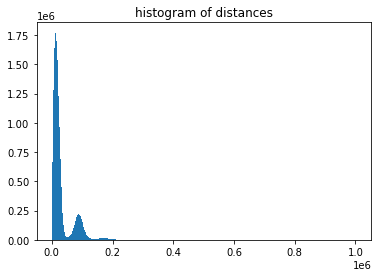

In [66]:
plt.title("histogram of distances")
fig11 = plt.hist(distances, 1000)

In [67]:
hdb = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True).fit(rDataD)
labels = hdb.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

counts = np.zeros(n_clusters)
for i in range(n_clusters):
    for label in labels:
        if label == i:
            counts[i] += 1
            
percentage_counts = counts/len(data)
for i in range(len(percentage_counts)):
    percentage_counts[i] = round(percentage_counts[i], 3)

In [68]:
print ("Number of clusters: " + str(n_clusters))
print ("Number of noise points: " + str(n_noise))
print ("% of data included in clustering: " + str (1 - n_noise/len(labels)))

Number of clusters: 5
Number of noise points: 102
% of data included in clustering: 0.9897600642505773


<AxesSubplot:ylabel='$\\lambda$ value'>

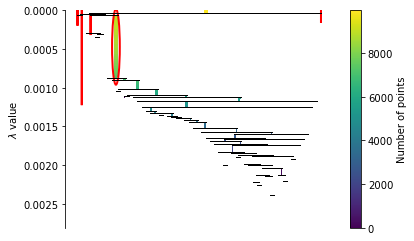

In [69]:
hdb.condensed_tree_.plot(select_clusters=True)

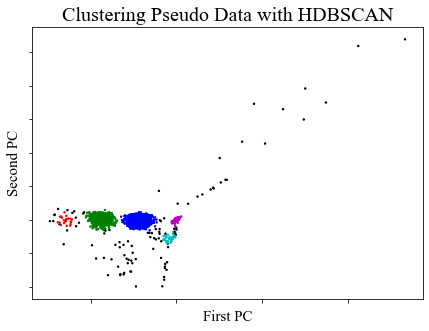

In [73]:
cvec = [colors[label] for label in labels]
fig, ax = plt.subplots(figsize = (7,5))
scatter = ax.scatter(-1*rDataD[:,0], rDataD[:,1], s=2, c=cvec, cmap='turbo')
ax.set_title('Clustering Pseudo Data with HDBSCAN', fontdict=csfont, size=20)
ax.set_xlabel('First PC', **csfont, size=15)
ax.set_ylabel('Second PC', **csfont, size=15)
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.savefig('Clustered_Lifetime_PData_HDBSCAN.png')

Text(0, 0.5, 'Principle Component 2')

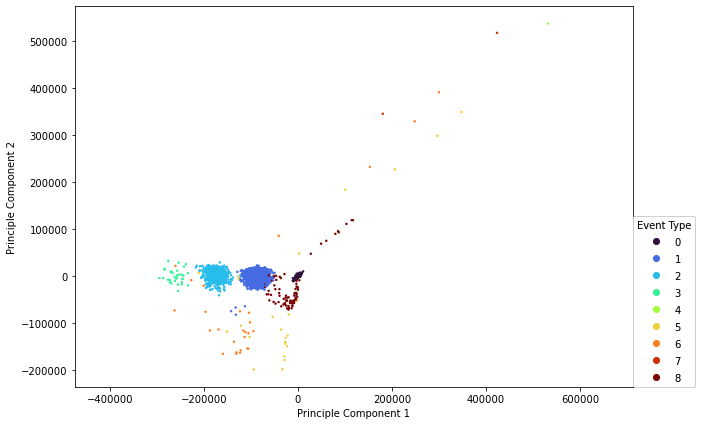

In [31]:
fig, ax = plt.subplots(figsize = (10,7))

scatter = ax.scatter(-1*rDataD[:,0], rDataD[:,1], s=2, c=truthTable, cmap='turbo')
plt.axis("equal")

# produce a legend with the unique colors corresponding to digits
legend = ax.legend(*scatter.legend_elements(),loc=(1,0), title="Event Type")
ax.add_artist(legend)
ax.set_xlabel("Principle Component 1")
ax.set_ylabel("Principle Component 2")

KeyboardInterrupt: 

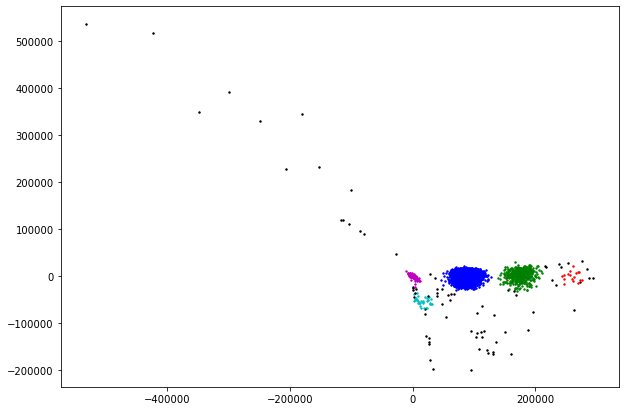

In [22]:
cvec = [colors[label] for label in labels]
x = rDataD[:,0]
y = rDataD[:,1]
fig, ax = plt.subplots(figsize = (10,7))
for i in range(len(labels)): #NOTE: not nessecaryily all data being plotted
    ax.scatter(x[i],y[i], c = cvec[i], s=2)
ax.title.set_text('Clustering for HDB with min pts: ' + str(hdb.min_cluster_size))
plt.axis("equal")
plt.show()

In [ ]:
avgs = np.arange(2048)
counts = np.arange(n_clusters)
for i in range(n_clusters):
    tmp = np.arange(2048)
    tmp = tmp.astype(float)
    avgs = np.vstack((avgs, tmp))

In [ ]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(n_clusters+1, figsize = (20,50))
t = np.arange(2048)
for n in range(len(labels)):
    for i in range(-1, n_clusters):
        if i == labels[n]:
            #collecting averages
            avgs[i] += data[n]
            counts[i] += 1
            ax[i].plot(t, data[n])
            ax[i].title.set_text("Cluster " + str(i))
            ax[i].set_xlabel("time bins")
            ax[i].set_ylabel("Energy")
for i in range(n_clusters):
        text_x = ax[i].get_xlim()[1] - 0.4*(ax[i].get_xlim()[1] - ax[i].get_xlim()[0])
        text_y = ax[i].get_ylim()[1] - 0.1*(ax[i].get_ylim()[1] - ax[i].get_ylim()[0])
        ax[i].text(text_x, text_y, "Percentage of data in cluster: " + str(round(100*percentage_counts[i], 3)) + "%", bbox = props)
plt.show()

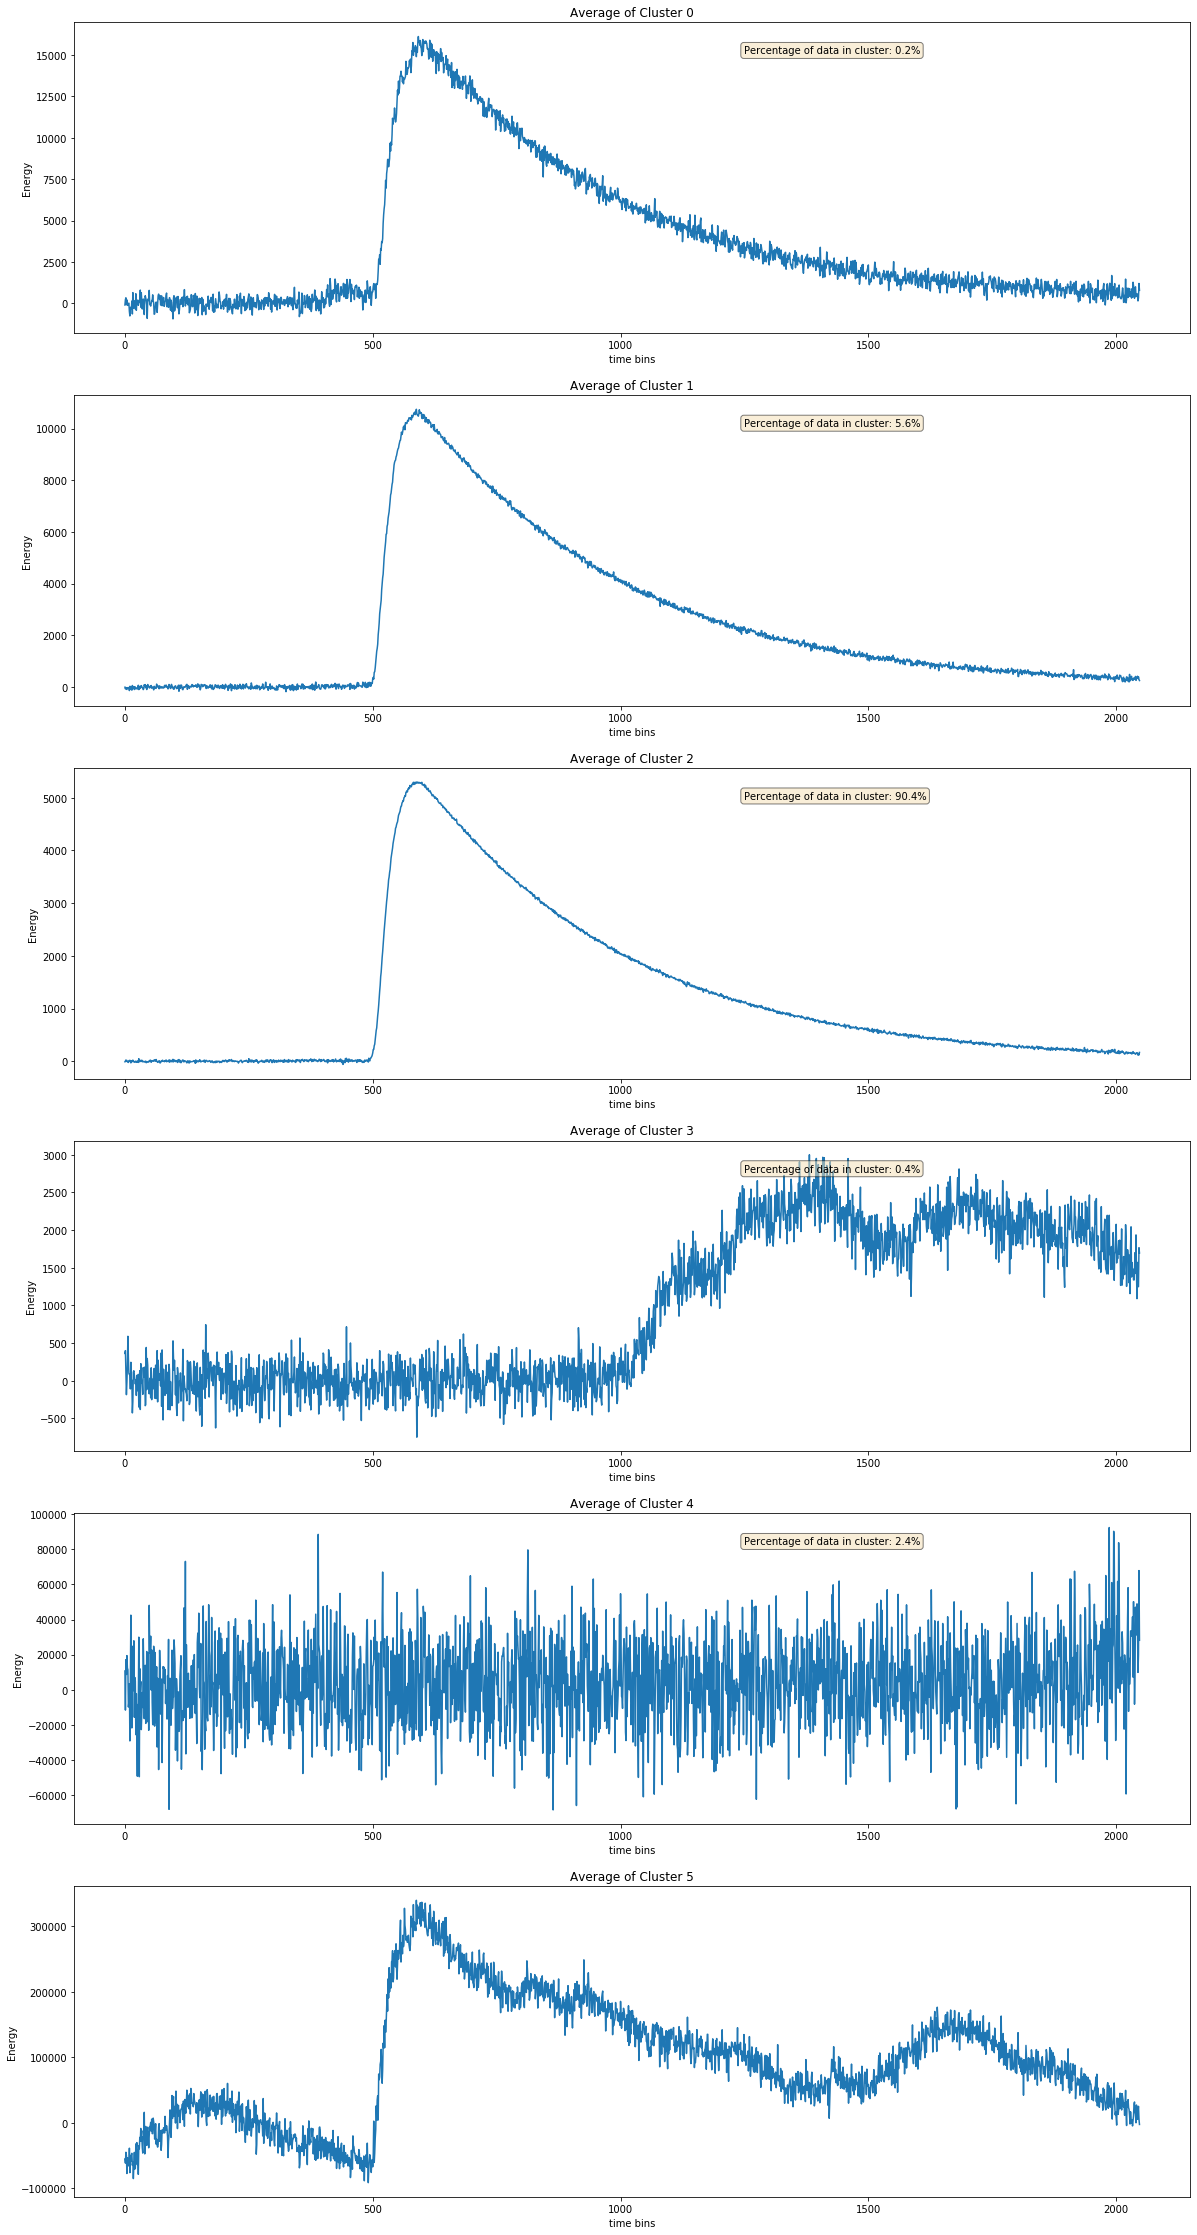

In [24]:
for i in range(n_clusters-1):
    avgs[i] = avgs[i]/counts[i]
    
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(len(avgs), figsize = (20,40))    
for i in range(len(avgs)):
    ax[i].plot(t, avgs[i])
    ax[i].title.set_text("Average of Cluster " + str(i))
    ax[i].set_xlabel("time bins")
    ax[i].set_ylabel("Energy")
for i in range(n_clusters):
    text_x = ax[i].get_xlim()[1] - 0.4*(ax[i].get_xlim()[1] - ax[i].get_xlim()[0])
    text_y = ax[i].get_ylim()[1] - 0.1*(ax[i].get_ylim()[1] - ax[i].get_ylim()[0])
    ax[i].text(text_x, text_y, "Percentage of data in cluster: " + str(round(100*percentage_counts[i], 3)) + "%", bbox = props)
plt.show()

In [25]:
truthLabels = np.array(["Pure Noise", "Single", "Double", "Triple", "Cosmic", "Electron", "E+P", "C+P", "Decay"])
clusterEvents = np.full(9, 0)
for i in range(-1,n_clusters-1):
    clusterEvents = np.vstack((clusterEvents, np.full(9, 0)))
print(clusterEvents)

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [26]:
for i in range(len(labels)):
    for j in range(-1, n_clusters):
        if(labels[i] == j):
            clusterEvents[j][truthTable[i]] += 1

In [27]:
df = pd.DataFrame(clusterEvents)
df.columns = truthLabels
df.index
df

,Pure Noise,Single,Double,Triple,Cosmic,Electron,E+P,C+P,Decay
0,0,0,0,20,0,0,1,0,0
1,0,0,552,0,0,1,1,0,0
2,0,8977,1,0,0,3,0,0,25
3,0,0,0,0,0,2,0,0,37
4,234,0,0,0,0,0,0,0,5
5,0,4,5,12,1,20,25,2,33


In [28]:
realLabels = labels
for i in range(len(labels)):
    if (label[i] == 0):
        realLabels[i] = 7
    if (label[i] == 1):
        realLabels[i] = 6 #
    if (label[i] == 2):
        realLabels[i] = 3
    if (label[i] == 3):
        realLabels[i] = 2
    if (label[i] == 4):
        realLabels[i] = 6
    if (label[i] == 5):
        realLabels[i] = 5
    if (label[i] == 6):
        realLabels[i] = 1

0      21
1     554
2    9006
3      39
4     239
5     102
dtype: int64

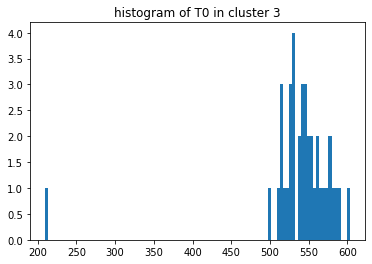

In [29]:
truthT0 = read_truth(Path("/Users/elicarter/Local/FominResearch/RealData/Runs/pseudoData/sim100k_proEventList.dat"))["T0"]
truthT0 = truthT0[:len(labels)]
truthT0_clust3 = truthT0[labels == 3]
plt.title("histogram of T0 in cluster 3")
fig11 = plt.hist(truthT0_clust3, 100)

In [30]:
print(len(truthT0_clust3))

39
